In [ ]:
!pip install tensorflow tensorflow-datasets gradio pillow numpy

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xzf maps.tar.gz


--2026-01-19 15:08:55--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   959KB/s    in 6m 31s  

2026-01-19 15:15:27 (625 KB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 400
BATCH_SIZE = 1
EPOCHS = 5

In [ ]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    return input_image, target_image


In [ ]:
def resize(input_image, target_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH])
    target_image = tf.image.resize(target_image, [IMG_HEIGHT, IMG_WIDTH])
    return input_image, target_image
def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image


In [ ]:
def load_train_image(image_file):
    input_image, target_image = load_image(image_file)
    input_image, target_image = resize(input_image, target_image)
    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image
train_dataset = tf.data.Dataset.list_files('maps/train/*.jpg')
train_dataset = train_dataset.map(load_train_image)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result


In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result


In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(256, 4, True),
        upsample(128, 4),
        upsample(64, 4),
    ]
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same', activation='tanh')
    return tf.keras.Model(inputs=inputs, outputs=last(x))

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256,256,3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    last = tf.keras.layers.Conv2D(
        1, 4, strides=1, padding='same',
        kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (LAMBDA * l1_loss)
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss


In [ ]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [ ]:
for epoch in range(EPOCHS):
    for input_image, target in train_dataset:
        train_step(input_image, target)


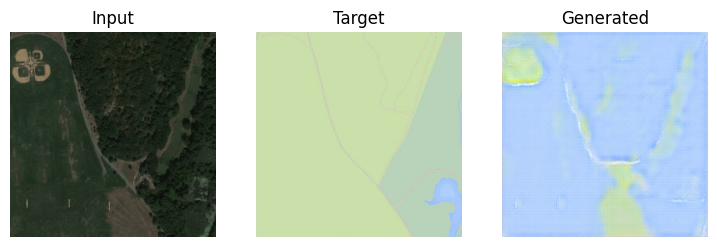

In [ ]:
for inp, tar in train_dataset.take(1):
    pred = generator(inp, training=False)

plt.figure(figsize=(9,3))
titles = ['Input', 'Target', 'Generated']
images = [inp[0], tar[0], pred[0]]

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    plt.imshow((images[i] + 1) / 2)
    plt.axis('off')


In [ ]:
import gradio as gr
from PIL import Image

In [ ]:
def preprocess_image(img):
    img = img.resize((256, 256))
    img = np.array(img).astype(np.float32)
    img = (img / 127.5) - 1
    img = tf.expand_dims(img, axis=0)
    return img
def postprocess_image(img):
    img = (img + 1) / 2
    img = img[0].numpy()
    img = (img * 255).astype(np.uint8)
    return img
def pix2pix_translate(input_image):
    input_tensor = preprocess_image(input_image)
    generated_image = generator(input_tensor, training=False)
    output_image = postprocess_image(generated_image)
    return output_image
interface = gr.Interface(
    fn=pix2pix_translate,
    inputs=gr.Image(type="pil", label="Input Image"),
    outputs=gr.Image(type="numpy", label="Generated Image"),
    title="Pix2Pix Image-to-Image Translation",
    description="Upload an image and generate its translated version using a Conditional GAN (Pix2Pix)."
)
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ca7b416b475bfbcf6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
